<a href="https://colab.research.google.com/github/xwang222/My-Projects/blob/main/PSM_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propensity Score Matching

This notebook is modified based on https://github.com/konosp/propensity-score-matching/blob/main/propensity_score_matching_v2.ipynb.

I used a different approach for common support and a different way to find the matched the sample.

In [1]:
# Loading libraries
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)}, font_scale=1.3)

# Enabled to remove warnings for demo purposes.
import warnings
warnings.filterwarnings('ignore')

# Define helper function
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

In [2]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/Titanic.csv')

# drop missing values
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df[~df.Sex.isna()]
df = df[~df.SibSp.isna()]
df = df[~df.Parch.isna()]
df = df[~df.Pclass.isna()]
df = df[~df.Fare.isna()]
df = df.reset_index()

# define LHS and RHS
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

In [3]:
# create treatment and covariates
df['treatment'] = np.where(df['Cabin'].isnull(), 0, 1)
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

# one-hot encoding for categorical variable
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=False)

In [4]:
# generate propensity score
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Survived

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Survived
X_encoded.loc[:,'treatment'] = df_data.treatment

In [5]:
# Common Support
X_encoded[['propensity_score_logit','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.max, np.min])

X_encoded=X_encoded[(X_encoded.propensity_score_logit>=-4.015084) & (X_encoded.propensity_score_logit<=2.225850)]
df_data=df_data[(df_data.propensity_score_logit>=-4.015084) & (df_data.propensity_score_logit<=2.225850)]

In [6]:
# trim extrem value
#X_encoded=X_encoded[(X_encoded.propensity_score_logit>X_encoded.propensity_score_logit.quantile(.01)) & (X_encoded.propensity_score_logit<X_encoded.propensity_score_logit.quantile(.99))]
#df_data=df_data[(df_data.propensity_score_logit>df_data.propensity_score_logit.quantile(.01)) & (df_data.propensity_score_logit<df_data.propensity_score_logit.quantile(.99))]

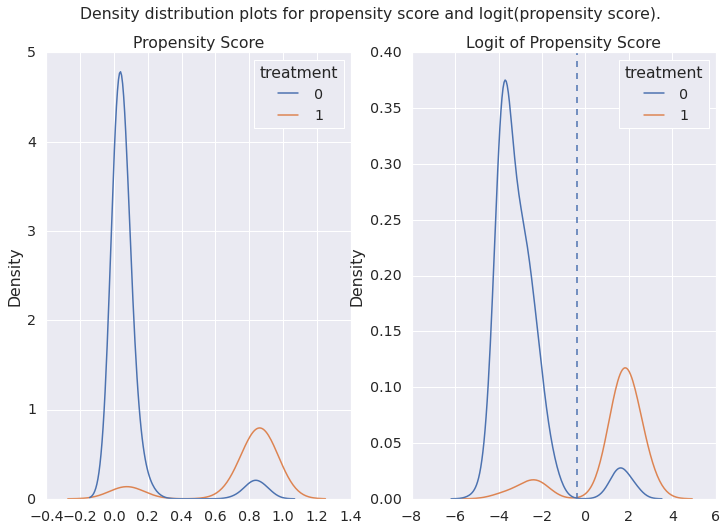

In [7]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

In [8]:
# Implement Matching
treat_pool=X_encoded[(X_encoded.treatment == 1)]
ctrl_pool=X_encoded[(X_encoded.treatment == 0)]

# find matched ctrl
caliper = np.std(df_data.propensity_score) * 0.25
print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))
df_data = X_encoded
knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(ctrl_pool[['propensity_score_logit']].to_numpy())    # reference pool

distances , indexes = knn.kneighbors(                        # target pool
    treat_pool[['propensity_score_logit']].to_numpy(), \
    n_neighbors=1)

match_ctrl_mastr=pd.DataFrame()

for i in range(len(treat_pool)):
  loc=indexes[i][0]
  match_ctrl_temp=ctrl_pool.iloc[[loc]]
  match_ctrl_mastr=match_ctrl_mastr.append(match_ctrl_temp, ignore_index=True)

# find matched treat
caliper = np.std(df_data.propensity_score) * 0.25
print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))
df_data = X_encoded
knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(treat_pool[['propensity_score_logit']].to_numpy())    # reference pool

distances , indexes = knn.kneighbors(                        # target pool
    ctrl_pool[['propensity_score_logit']].to_numpy(), \
    n_neighbors=1)

match_treat_mastr=pd.DataFrame()

for i in range(len(ctrl_pool)):
  loc=indexes[i][0]
  match_treat_temp=treat_pool.iloc[[loc]]
  match_treat_mastr=match_treat_mastr.append(match_treat_temp, ignore_index=True)


Caliper (radius) is: 0.0834


Caliper (radius) is: 0.0834



In [9]:
# prepare final dataset - wide
Final=treat_pool.append(ctrl_pool, ignore_index=True)
Final_match=match_ctrl_mastr.append(match_treat_mastr, ignore_index=True)
Final['match']=Final_match.outcome

# prepare final dataset for ATT - long 
ATT_df=treat_pool.append(match_ctrl_mastr, ignore_index=True)

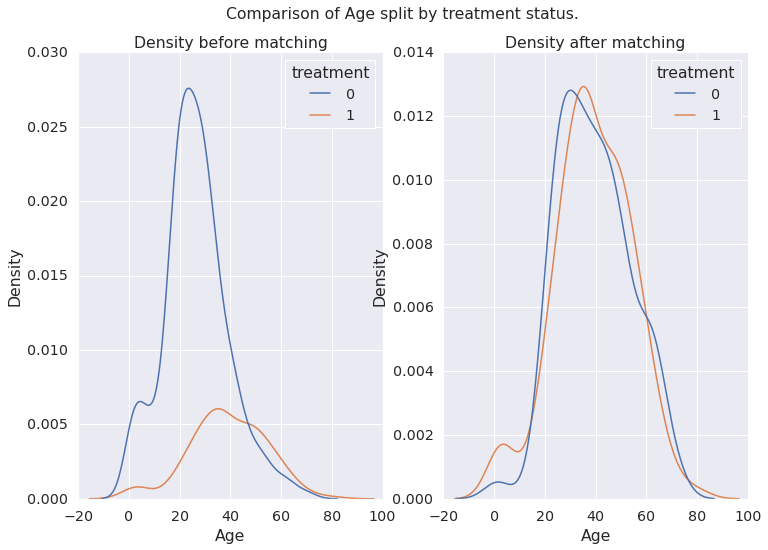

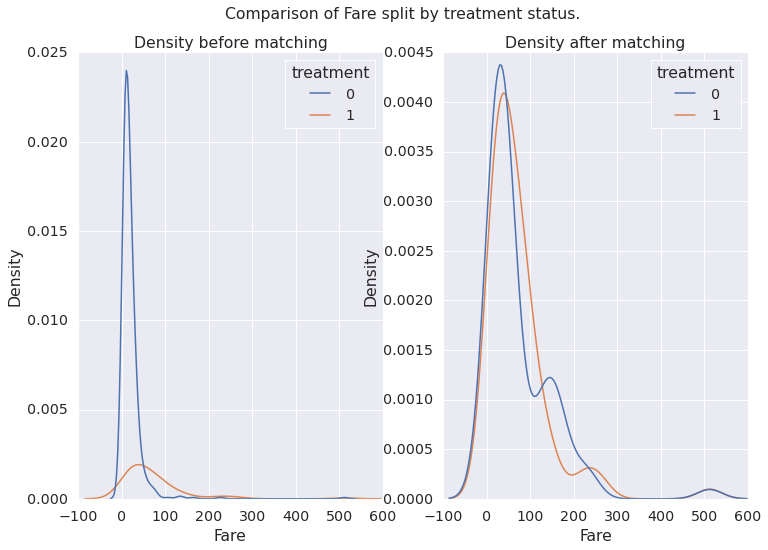

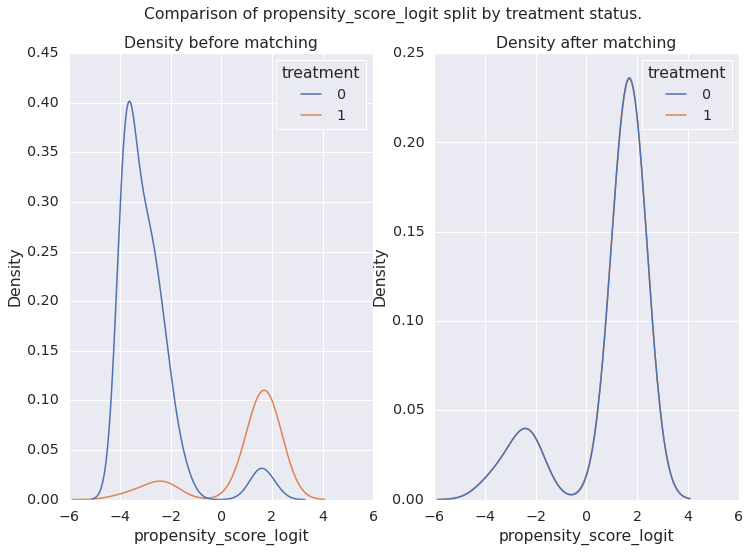

In [10]:
# Review Matching Quality
args = ['Age','Fare','propensity_score_logit']

def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = df_data, x = arg, hue = 'treatment', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = ATT_df, x = arg, hue = 'treatment',  ax = ax[1]).set(title='Density after matching')
    plt.show()
    fig.savefig("{}_comparison.png".format(arg))

for arg in args:
    plot(arg)

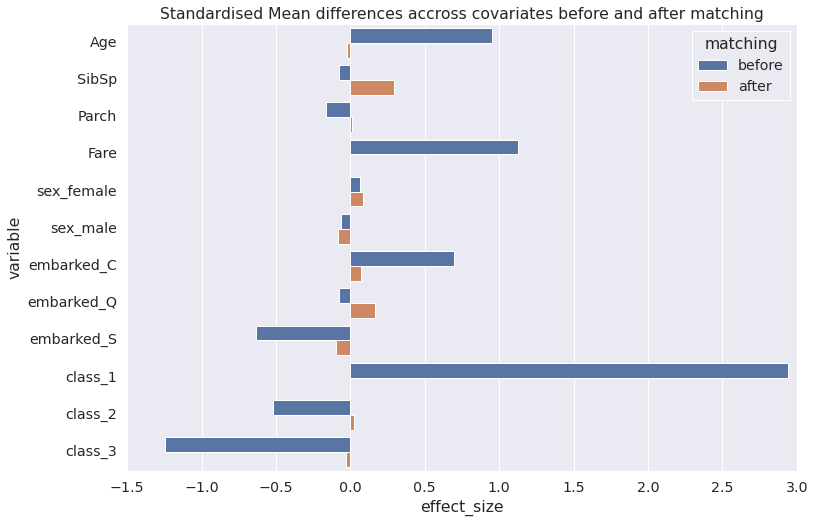

In [11]:
data = []
cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S','class_1','class_2','class_3']
# cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(ATT_df,cl)])

res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

sn_plot = sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h')
sn_plot.set(title='Standardised Mean differences accross covariates before and after matching')
sn_plot.figure.savefig("standardised_mean_differences.png")

In [12]:
# Estimate ATT with mean
overview = ATT_df[['outcome','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)

            outcome                          
               mean       var       std count
treatment                                    
0          0.500000  0.251724  0.501721   146
1          0.609589  0.239632  0.489522   146


In [13]:
# Estimate ATT with OLS

import statsmodels.formula.api as smf

# Initialise and fit linear regression model using `statsmodels`
model = smf.ols('outcome ~ treatment', data=ATT_df)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.569
Date:                Wed, 14 Sep 2022   Prob (F-statistic):             0.0599
Time:                        13:38:54   Log-Likelihood:                -208.38
No. Observations:                 292   AIC:                             420.8
Df Residuals:                     290   BIC:                             428.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5000      0.041     12.189      0.000       0.419       0.581
treatment      0.1096      0.058      1.889      0.060      -0.005       0.224
==============================================================================
Omnibus:                     1482.627   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.357
Skew:                          -0.216   Prob(JB):                     8.59e-11
Kurtosis:                       1.097   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""